In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, cross_validate, StratifiedKFold
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc,confusion_matrix, RocCurveDisplay,accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Load the data
df = pd.read_csv('Loan_Data/model_selected_data.csv')

# Initial exploration
print(df.info())
print(df.describe())
print(df['Default_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DAYS_TO_MATURITY             827 non-null    float64
 1   previous_loan_default_count  827 non-null    float64
 2   Is_Active_loans_Inactive     827 non-null    float64
 3   ARR_STATUS_CURRENT           827 non-null    float64
 4   DAY_SINCEPAYMENT             827 non-null    float64
 5   CURR_BAL                     827 non-null    float64
 6   DAYS_RUNNING_SINCE           827 non-null    float64
 7   previous_loans_count         827 non-null    float64
 8   INTEREST_RATE                827 non-null    float64
 9   sector_GENERAL               827 non-null    float64
 10  Default_status               827 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 71.2 KB
None
       DAYS_TO_MATURITY  previous_loan_default_count  \
count      8.270000e+02     

In [30]:
# Separate features and target
X = df.copy().drop('Default_status', axis=1)
y=df.copy()['Default_status']

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DAYS_TO_MATURITY             827 non-null    float64
 1   previous_loan_default_count  827 non-null    float64
 2   Is_Active_loans_Inactive     827 non-null    float64
 3   ARR_STATUS_CURRENT           827 non-null    float64
 4   DAY_SINCEPAYMENT             827 non-null    float64
 5   CURR_BAL                     827 non-null    float64
 6   DAYS_RUNNING_SINCE           827 non-null    float64
 7   previous_loans_count         827 non-null    float64
 8   INTEREST_RATE                827 non-null    float64
 9   sector_GENERAL               827 non-null    float64
dtypes: float64(10)
memory usage: 64.7 KB


In [42]:
# Check class imbalance
print(f"Class distribution: {y.value_counts(normalize=True)}")


Class distribution: Default_status
0    0.573156
1    0.426844
Name: proportion, dtype: float64


In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DAYS_TO_MATURITY             827 non-null    float64
 1   previous_loan_default_count  827 non-null    float64
 2   Is_Active_loans_Inactive     827 non-null    float64
 3   ARR_STATUS_CURRENT           827 non-null    float64
 4   DAY_SINCEPAYMENT             827 non-null    float64
 5   CURR_BAL                     827 non-null    float64
 6   DAYS_RUNNING_SINCE           827 non-null    float64
 7   previous_loans_count         827 non-null    float64
 8   INTEREST_RATE                827 non-null    float64
 9   sector_GENERAL               827 non-null    float64
dtypes: float64(10)
memory usage: 64.7 KB


In [62]:
# with the outcome, logistic regression being the worst, others having 100 percent accuracy indicates
#possibility of overfitting, there is need to retrain using cross validation and test again






# ----------------------------
# 1. Split data
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ----------------------------
# 2. Define models
# ----------------------------
models_for_cv = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# ----------------------------
# 3. Cross-validation on TRAIN SET
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_for_cv.items():
    print(f"\n{name} Cross-Validation Results (on Train Set):")
    
    # CV Accuracy
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"CV Accuracy: Mean = {cv_accuracy.mean():.4f}, Std = {cv_accuracy.std():.4f}")
    
    # CV ROC AUC
    cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"CV ROC AUC: Mean = {cv_roc_auc.mean():.4f}, Std = {cv_roc_auc.std():.4f}")
    
    # Additional metrics
    scoring = ['precision', 'recall', 'f1']
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    print(f"CV Precision: Mean = {cv_results['test_precision'].mean():.4f}")
    print(f"CV Recall: Mean = {cv_results['test_recall'].mean():.4f}")
    print(f"CV F1-Score: Mean = {cv_results['test_f1'].mean():.4f}")

# ----------------------------
# 4. Train & Evaluate on TEST SET + Capture Importances
# ----------------------------
feature_importances = []

for name, model in models_for_cv.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(f"\n{name} Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    if y_pred_proba is not None:
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
   



Logistic Regression Cross-Validation Results (on Train Set):
CV Accuracy: Mean = 0.8962, Std = 0.0145
CV ROC AUC: Mean = 0.9704, Std = 0.0082
CV Precision: Mean = 0.8810
CV Recall: Mean = 0.8783
CV F1-Score: Mean = 0.8784

Random Forest Cross-Validation Results (on Train Set):
CV Accuracy: Mean = 1.0000, Std = 0.0000
CV ROC AUC: Mean = 1.0000, Std = 0.0000
CV Precision: Mean = 1.0000
CV Recall: Mean = 1.0000
CV F1-Score: Mean = 1.0000

Gradient Boosting Cross-Validation Results (on Train Set):
CV Accuracy: Mean = 1.0000, Std = 0.0000
CV ROC AUC: Mean = 1.0000, Std = 0.0000
CV Precision: Mean = 1.0000
CV Recall: Mean = 1.0000
CV F1-Score: Mean = 1.0000

XGBoost Cross-Validation Results (on Train Set):
CV Accuracy: Mean = 1.0000, Std = 0.0000


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site

CV ROC AUC: Mean = 1.0000, Std = 0.0000
CV Precision: Mean = 1.0000
CV Recall: Mean = 1.0000
CV F1-Score: Mean = 1.0000

Logistic Regression Test Set Results:
Accuracy: 0.8795
ROC AUC: 0.9592
Precision: 0.8878
Recall: 0.8208
F1-Score: 0.8529

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       143
           1       0.89      0.82      0.85       106

    accuracy                           0.88       249
   macro avg       0.88      0.87      0.88       249
weighted avg       0.88      0.88      0.88       249



/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site


Random Forest Test Set Results:
Accuracy: 1.0000
ROC AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       106

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249


Gradient Boosting Test Set Results:
Accuracy: 1.0000
ROC AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       106

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249


XGBoost Test Set Results:
Accuracy: 1.0000
ROC AUC: 1.0000


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#### Conclusion
#From the assessment, Random Forest,Gradient Boosting and XGBboosting seems not to be the best as 100%
#accuracy, it seems to be extremely overfit and likely to be reliable models, there is need to check
# the feature spreed in contribution to to the predictions compared with logistics regression


In [55]:
feature_importances = []

for name, model in models_for_cv.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(f"\n{name} Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    if y_pred_proba is not None:
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # ----------------------------
    # Collect feature importances
    # ----------------------------
    if hasattr(model, "feature_importances_"):  # Tree models
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):  # Logistic Regression
        importances = np.abs(model.coef_[0])  # absolute coefficients
    else:
        importances = None
    
    if importances is not None:
        fi_df = pd.DataFrame({
            "feature": X.columns,
            "importance": importances,
            "model": name
        })
        feature_importances.append(fi_df)
        feature_importances.append(fi_df)

# Combine all feature importance dataframes
all_importances = pd.concat(feature_importances, axis=0).sort_values(by=["model", "importance"], ascending=[True, False])

# Display or save
print("\nCombined Feature Importances:\n", all_importances)


Logistic Regression Test Set Results:
Accuracy: 0.8795
ROC AUC: 0.9592
Precision: 0.8878
Recall: 0.8208
F1-Score: 0.8529

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       143
           1       0.89      0.82      0.85       106

    accuracy                           0.88       249
   macro avg       0.88      0.87      0.88       249
weighted avg       0.88      0.88      0.88       249


Random Forest Test Set Results:
Accuracy: 1.0000
ROC AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       106

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249


Gradient Boosting Test Set Results:
Accuracy: 1.0000
ROC 

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:15:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/tmp/ipykernel_2112/1813678101.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.nlargest(10, "importance"))


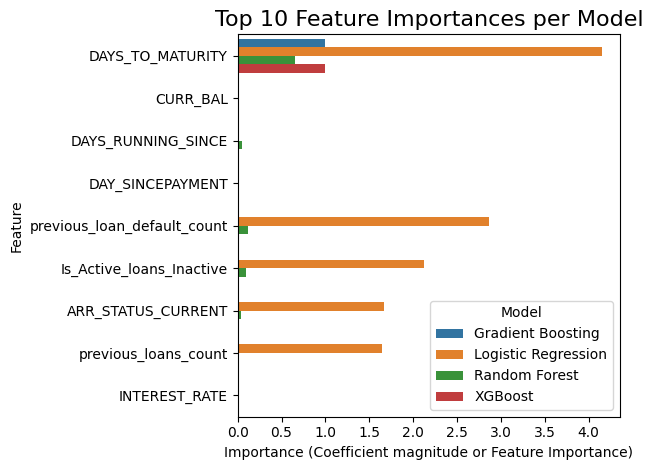

In [81]:
top_features = (
    all_importances.groupby("model", group_keys=False)
    .apply(lambda df: df.nlargest(10, "importance"))
)


sns.barplot(
    data=top_features,
    x="importance",
    y="feature",
    hue="model",
    dodge=True
)

plt.title("Top 10 Feature Importances per Model", fontsize=16)
plt.xlabel("Importance (Coefficient magnitude or Feature Importance)")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [ ]:
#from the graph,Gradient boosting,XGBOOST only have days to maturity as the only basis for prediction whcih
#will not be good model,followed by Random forest that is spread across features.Logistic Regression 
#becomes the choice for prediction as its not overfitted and prediction has a wider spread based on features with days
# to maturity being the dominant feature

In [73]:
rf_model = models_for_cv['Logistic Regression']

# Predict labels
rf_preds = rf_model.predict(X_test)

# Predict probabilities (for ROC AUC if available)
rf_proba = rf_model.predict_proba(X_test)[:, 1] if hasattr(rf_model, "predict_proba") else None

# Accuracy
print("Accuracy:", accuracy_score(y_test, rf_preds))

# Precision, Recall, F1
print("Precision:", precision_score(y_test, rf_preds))
print("Recall:", recall_score(y_test, rf_preds))
print("F1-Score:", f1_score(y_test, rf_preds))

Accuracy: 0.8795180722891566
Precision: 0.8877551020408163
Recall: 0.8207547169811321
F1-Score: 0.8529411764705882


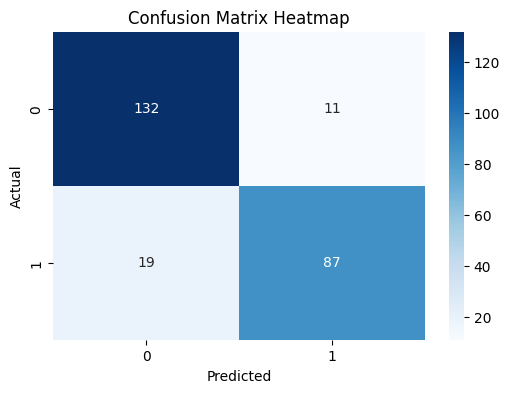

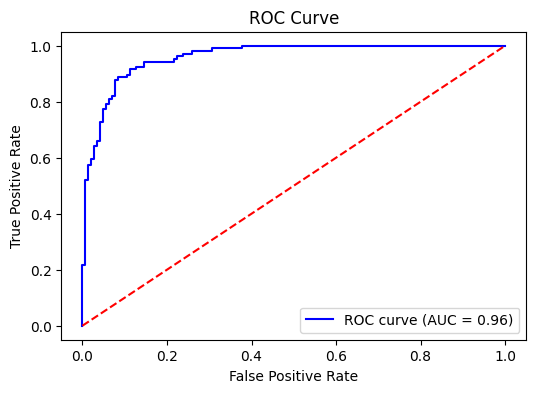

In [82]:
# ---- Confusion Matrix Heatmap ----
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# ---- ROC Curve ----
if rf_proba is not None:
    fpr, tpr, thresholds = roc_curve(y_test, rf_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [83]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga', 'liblinear']
}

# Base model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',   # Better for imbalance than accuracy
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search.fit(X_train, y_train)


hypertuned_rf_model = grid_search.best_estimator_

print("Best Logistic Regression Parameters:", grid_search.best_params_)
print("Best CV ROC AUC:", grid_search.best_score_)

# ---- Evaluate tuned model on test set ----
hypertuned_rf_preds = rf_model.predict(X_test)
hypertuned_rf_proba = rf_model.predict_proba(X_test)[:, 1]

print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, hypertuned_rf_preds))
print("ROC AUC:", roc_auc_score(y_test, hypertuned_rf_proba))
print("Precision:", precision_score(y_test, hypertuned_rf_preds))
print("Recall:", recall_score(y_test, hypertuned_rf_preds))
print("F1-Score:", f1_score(y_test, hypertuned_rf_preds))
print("\nClassification Report:\n", classification_report(y_test, hypertuned_rf_preds))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ...............C=1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ...............C=1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ...............C=1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ...............C=1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..........C=1, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ..........C=1, pena

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..............C=10, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..............C=10, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..............C=10, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..............C=10, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..............C=10, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=10, pena

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   9.2s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   9.7s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   9.4s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   9.7s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................C=10, penalty=l1, solver=liblinear; total time=  10.3s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time=  10.7s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   9.6s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   9.7s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   9.3s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.2s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ........C=100, pena

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   9.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
------------------------------------------------------------------

[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best CV ROC AUC: 1.0

Test Set Metrics:
Accuracy: 0.8795180722891566
ROC AUC: 0.9592294497954875
Precision

<Figure size 1000x600 with 0 Axes>

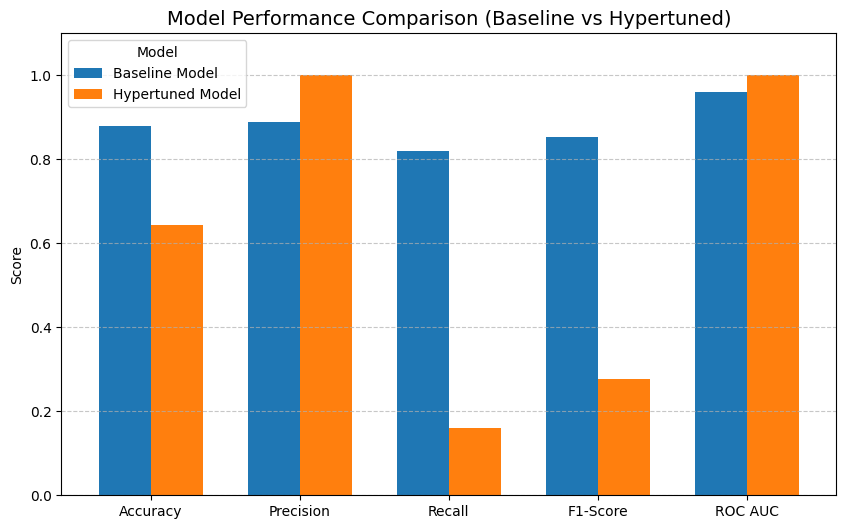

In [85]:


# --- Baseline Model Metrics ---
rf_preds = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

baseline_metrics = {
    "Accuracy": accuracy_score(y_test, rf_preds),
    "Precision": precision_score(y_test, rf_preds),
    "Recall": recall_score(y_test, rf_preds),
    "F1-Score": f1_score(y_test, rf_preds),
    "ROC AUC": roc_auc_score(y_test, rf_proba)
}

# --- Hypertuned Model Metrics ---
hypertuned_rf_preds = hypertuned_rf_model.predict(X_test)
hypertuned_rf_proba = hypertuned_rf_model.predict_proba(X_test)[:, 1]

hypertuned_metrics = {
    "Accuracy": accuracy_score(y_test, hypertuned_rf_preds),
    "Precision": precision_score(y_test, hypertuned_rf_preds),
    "Recall": recall_score(y_test, hypertuned_rf_preds),
    "F1-Score": f1_score(y_test, hypertuned_rf_preds),
    "ROC AUC": roc_auc_score(y_test, hypertuned_rf_proba)
}

# --- Combine into DataFrame for Plotting ---

metrics_df = pd.DataFrame([baseline_metrics, hypertuned_metrics],
                          index=["Baseline Model", "Hypertuned Model"]).T

# --- Plot Side-by-Side Comparison ---
plt.figure(figsize=(10,6))
metrics_df.plot(kind="bar", figsize=(10,6), width=0.7)
plt.title("Model Performance Comparison (Baseline vs Hypertuned)", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [87]:
# from the assessment, the baseline models performed better across all metrics and so will be retained
import joblib

# Save trained model
joblib.dump(rf_model, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']